# Lecture 9: Stochastic Gradient Descent and Vowpal Wabbit

The first thing to note is that this is **NOT** a regular ipython notebook.  It uses the bash kernel that you need to install from [here](https://github.com/takluyver/bash_kernel) to execute normal linux commands rather than just regular python.  You need ipython version 3 for it to work.  It's pretty sweet though--you can switch back and forth between executing linux commands and python commands by going to the "Change kernel" option in the "Kernel" menu above.

We'll be looking at a dataset of display ad click logs from online display advertising from Criteo.  It's a much larger version of a [Kaggle competition dataset](https://www.kaggle.com/c/criteo-display-ad-challenge).  The dataset is a terabyte and has records for 24 days, but we'll only be looking at a single day of data.  You can get the data [here](http://labs.criteo.com/downloads/download-terabyte-click-logs/).  There's also a nice [blog post](http://fastml.com/vowpal-wabbit-eats-big-data-from-the-criteo-competition-for-breakfast/) about using VW in the Criteo contest.

Let's see how large the file is:

In [ ]:
ls -lh data/day_0

46 GB is pretty gigantic, and clearly to large to load into my laptop's RAM.  So VW is a good option here.  Let's see how many lines (examples there are in the file):

In [ ]:
# THIS WILL TAKE A LONG TIME
wc -l data/day_0
#195,841,983

Let's take a look at the first two lines of the file:

In [1]:
head -2 data/day_0

1	5	110		16		1	0	14	7	1		306		62770d79	e21f5d58	afea442f	945c7fcf	38b02748	6fcd6dcb	3580aa21	28808903	46dedfa6	2e027dc1	0c7c4231	95981d1f	00c5ffb7	be4ee537	8a0b74cc	4cdc3efa	d20856aa	b8170bba	9512c20b	c38e2f28	14f65a5d	25b1b089	d7c1fc0b	7caf609c	30436bfc	ed10571d
0	32	3	5		1	0	0	61	5	0	1	3157	5	e5f3fd8d	a0aaffa6	6faa15d5	da8a3421	3cd69f23	6fcd6dcb	ab16ed81	43426c29	1df5e154	7de9c0a9	6652dc64	99eb4e27	00c5ffb7	be4ee537	f3bbfe99	4cdc3efa	d20856aa	a1eb1511	9512c20b	febfd863	a3323ca1	c8e1ee56	1752e9e8	75350c8a	991321ea	b757e957


Here's a description of the dataset from the Criteo website:

The columns are tab separated with the following schema:<br>
&lt;label&gt; &lt;integer feature 1&gt; … &lt;integer feature 13&gt; &lt;categorical feature 1&gt; … &lt;categorical feature 26&gt;
When a value is missing, the field is just empty.

So the first field is the target value (a 1 when someone clicked on the ad, a 0 when the didn't).  Then we have numeric features, and a bunch of categorical features which we would normally need to expand out into dummies.

We'll be using vowpal wabbit, which you can get from github [here](https://github.com/JohnLangford/vowpal_wabbit).  We'll be working with version 7.7, though I doubt the particular version is crucial.  Windows installation instructions here [here](https://github.com/JohnLangford/vowpal_wabbit/blob/master/README.windows.txt), though I've never tried to get it working on Windows, so YMMV.

In [2]:
vw --version

7.7.0


VW has a huge array of commandline options, which you can read about from the help menu:

In [3]:
vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg               seed random number generator
  --ring_size arg                 size of example ring

Update options:
  -l [ --learning_rate ] arg Set learning rate
  --power_t arg              t power value
  --decay_learning_rate arg  Set Decay factor for learning_rate between passes
  --initial_t arg            initial t value
  --feature_mask arg         Use existing regressor to determine which 
                             parameters may be updated.  If no 
                             initial_regressor given, also used for initial 
                             weights.

Weight options:
  -i [ --initial_regressor ] arg  Initial regressor(s)
  --initial_weight arg            Set all weights to an initial value of 1.
  --random_weights arg            make initial weights random
  --input_feature_regularizer arg Per feature regulariza

The first thing that we need to do is to convert the log file into the input format that VW expects.  VW comes with a utility called `vw-csv2bin`, but we're going to write some simple python code to do that:

In [ ]:
import re

In [ ]:
def tsv_to_vw(tsv_file, vw_file, skip_lines, num_lines):
    print "\nTurning %s into %s..." % (tsv_file, vw_file)

    # open our input file and an output file to write to
    with open(tsv_file, 'r') as infile, open(vw_file, 'w') as outfile:        
        lines_read=0
        lines_skipped=0
        # read the file line by line
        for line in infile:
            # we want to skip the first skip_lines lines of the file
            if skip_lines!=0 and lines_skipped<skip_lines:
                lines_skipped += 1
                continue
  
            # if we've converted num_lines already, stop
            if lines_read>= num_lines: return

            # othewise, convert the line
            out_line = ""
            # get rid of the newline at the end of the line
            line = re.sub('\n', '', line)
            # split the file on tabs
            data = re.split('\t', line)

            # pop off our target/label column and write the label | for vw
            target = data.pop(0)        
            out_line += "1 | " if target == "1" else "-1 | "

            # write the 13 integer features in a form like feature:val, e.g. f0:124
            for i in range(13):
                out_line += "f%s:" % i
                if data[i] == "":
                    out_line += "0 "
                else:
                    out_line += "%s " % data[i]

            # all the rest are the categorical features, so we just write these directly
            # and vw will interpet them as F:1 when they're present, F:0 when they're not
            for i in range(13, len(data)):
                if data[i] == "": continue
                out_line += "f%s_%s " % (i, data[i])

            out_line += "\n"
            outfile.write(out_line)
            lines_read += 1

In [ ]:
# DON'T RE-RUN THIS, BECAUSE IT WILL TAKE FOREVER...
# also, only write out 2mm lines because my hard drive fills up...
tsv_to_vw("data/day_0", "data/day_0.vw", skip_lines=0, num_lines=2000000)

In [ ]:
tsv_to_vw("data/day_0", "data/day_0.test.vw", skip_lines=2000000, num_lines=2000000)

In [1]:
head -10 data/day_0.vw

1 | f0:5 f1:110 f2:0 f3:16 f4:0 f5:1 f6:0 f7:14 f8:7 f9:1 f10:0 f11:306 f12:0 f13_62770d79 f14_e21f5d58 f15_afea442f f16_945c7fcf f17_38b02748 f18_6fcd6dcb f19_3580aa21 f20_28808903 f21_46dedfa6 f22_2e027dc1 f23_0c7c4231 f24_95981d1f f25_00c5ffb7 f26_be4ee537 f27_8a0b74cc f28_4cdc3efa f29_d20856aa f30_b8170bba f31_9512c20b f32_c38e2f28 f33_14f65a5d f34_25b1b089 f35_d7c1fc0b f36_7caf609c f37_30436bfc f38_ed10571d 
-1 | f0:32 f1:3 f2:5 f3:0 f4:1 f5:0 f6:0 f7:61 f8:5 f9:0 f10:1 f11:3157 f12:5 f13_e5f3fd8d f14_a0aaffa6 f15_6faa15d5 f16_da8a3421 f17_3cd69f23 f18_6fcd6dcb f19_ab16ed81 f20_43426c29 f21_1df5e154 f22_7de9c0a9 f23_6652dc64 f24_99eb4e27 f25_00c5ffb7 f26_be4ee537 f27_f3bbfe99 f28_4cdc3efa f29_d20856aa f30_a1eb1511 f31_9512c20b f32_febfd863 f33_a3323ca1 f34_c8e1ee56 f35_1752e9e8 f36_75350c8a f37_991321ea f38_b757e957 
-1 | f0:0 f1:233 f2:1 f3:146 f4:1 f5:0 f6:0 f7:99 f8:7 f9:0 f10:1 f11:3101 f12:1 f13_62770d79 f14_ad984203 f15_62bec60d f16_386c49ee f17_e755064d f18_6fcd6dcb f19_b5f

We can validate the format with the super useful [VW format validator tool](http://hunch.net/~vw/validate.html
).

Next, we'll train a logistic regression model.  The `-f` flag tells it where to store the final model, and the `-d` option is for the input data.  (Note, this provides realtime feedback in the terminal that you can't see in the notebook...)

In [ ]:
vw --loss_function logistic -f data/day_0.model -d data/day_0.vw

Instead of displaying the logistic loss function values, we can have it display the binary accuracy instead:

In [ ]:
vw --loss_function logistic --binary -f data/day_0.model -d data/day_0.vw

The dataset is 94% 0's, so getting an accuracy of 97% means that it is indeed learning something about the 1's.

We can have VW make multiple passes over the data.  In general, the more passes the better:

In [ ]:
vw --loss_function logistic --binary -f data/day_0.model -d data/day_0.vw -c --passes 2

And we can apply the model to new data with the `-t` flag.  Predictions will be written to the file specified by the `-p` flag and raw predictions to the file specified by the `-r` flag:

In [ ]:
vw -t --binary -i data/day_0.model -d data/day_0.test.vw -p data/day_0.test.preds -r data/day_0.test.raw.preds

In [ ]:
head -10 data/day_0.test.preds

In [ ]:
head -10 data/day_0.test.raw.preds

Let's write a file with only the true test predictions:

In [ ]:
cut -d "|" -f 1 data/day_0.test.vw > data/day_0.test.true.labels

In [ ]:
head -10 data/day_0.test.true.labels

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
labels = pd.read_csv("data/day_0.test.true.labels", header=None)
labels.columns = ["label"]
labels.head()

,label
0,-1
1,-1
2,-1
3,-1
4,-1


In [4]:
preds = pd.read_csv("data/day_0.test.raw.preds", header=None)
preds.columns = ["pred"]
preds.head()

,pred
0,-6.131194
1,-4.305913
2,-5.647429
3,-2.926275
4,-4.201283


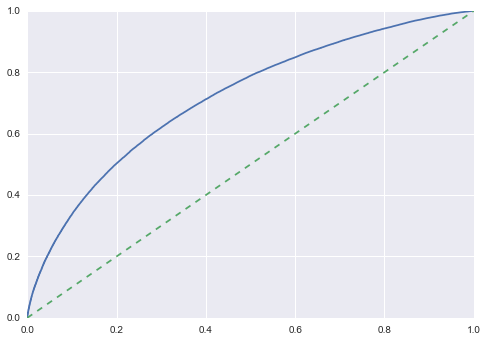

In [5]:
fpr, tpr, thresholds = roc_curve(labels.label, preds.pred)
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

plt.plot(fpr, tpr)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [6]:
roc_auc_score(labels.label, preds.pred)

0.71823137507417334

We can tell VW to generate all quadratic interaction features and use them in the model:

In [7]:
vw --loss_function logistic --binary -q aa -b 24 -d data/day_0.vw

SyntaxError: invalid syntax (<ipython-input-7-8469a05caee3>, line 1)

Same with cubic features:

In [ ]:
vw --loss_function logistic --binary --cubic aaa -d data/day_0.vw

We can add lasso or ridge penalties to the model:

In [ ]:
vw --loss_function logistic --binary --l1 0.1 -d data/day_0.vw

In [ ]:
vw --loss_function logistic --binary --l2 0.1 -d data/day_0.vw

If we had defined feature namespaces, we can mask entire chunks of features in and out of the model with the `--ignore` and `--keep` options.

We can get an idea of feature importances with the `vw-varinfo` script.  Let's first generate a tiny version of our training dataset so that this will go quickly:

In [ ]:
head -1000 data/day_0.vw > data/day_0.small.vw

In [ ]:
vw-varinfo -d data/day_0.small.vw

Finally, we can also train a support vector machine by using the "hinge" loss function:

In [ ]:
vw --loss_function hinge --binary -f data/day_0.model -d data/day_0.vw